In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import obonet
from tqdm import tqdm
import warnings

import os
warnings.filterwarnings('ignore')

from Dataset.GoDataset import GOTermDataset, get_class_frequencies_from_dataframe
from Model.ProtienGOClassifier_pl import ProteinGOClassifierLightning
from Dataset.utils import prepare_data, read_fasta, prepare_data_range

/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

BASE_PATH = "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction"


go_graph = obonet.read_obo(os.path.join(BASE_PATH, 'Train/go-basic.obo'))
print(f"Gene Ontology graph loaded with {len(go_graph)} nodes and {len(go_graph.edges)} edges.")

train_terms_df = pd.read_csv(os.path.join(BASE_PATH, 'Train/train_terms.tsv'), sep='\\t')
print(f"Training terms loaded. Shape: {train_terms_df.shape}")


train_fasta_path = os.path.join(BASE_PATH, 'Train/train_sequences.fasta')

test_fasta_path = os.path.join(BASE_PATH, 'Test/testsuperset.fasta')

ia_df = pd.read_csv(os.path.join(BASE_PATH, 'IA.tsv'), sep='\\t', header=None, names=['term_id', 'ia_score'])
ia_map = dict(zip(ia_df['term_id'], ia_df['ia_score']))
print(train_terms_df['aspect'].value_counts().reset_index())

train_seq = read_fasta(train_fasta_path)
test_seq = read_fasta(test_fasta_path)

Gene Ontology graph loaded with 40122 nodes and 77229 edges.
Training terms loaded. Shape: (537027, 3)
  aspect   count
0      P  250805
1      C  157770
2      F  128452
[io] Read 82404 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_sequences.fasta
[io] Read 224309 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Test/testsuperset.fasta


In [4]:
# top_k = 64
top_range = [1, 65]
test_size = 0.2
data = prepare_data_range(train_terms_df, train_seq, ia_df, top_range=top_range)

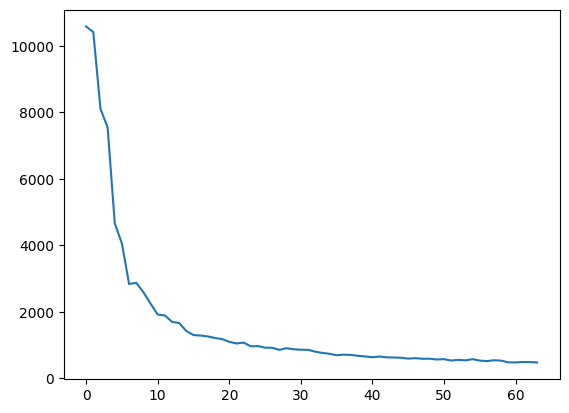

In [4]:
#plot the class frequencies 
import matplotlib.pyplot as plt 
freq = data['train_labels'].sum(axis=0)
# freq = get_class_frequencies_from_dataframe(
#             train_terms_df, data['top_terms']
#         )

plt.plot(freq)

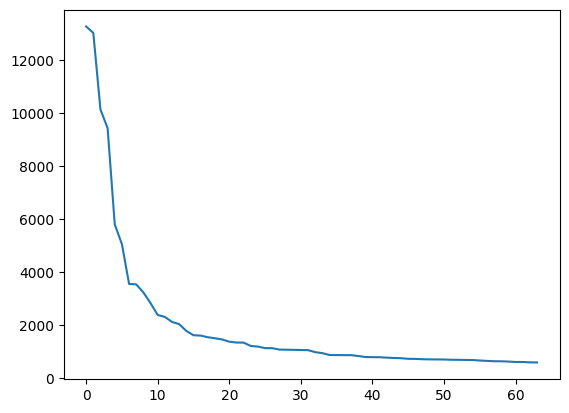

In [19]:
import matplotlib.pyplot as plt 
# freq = data['train_labels'].sum(axis=0)
freq = get_class_frequencies_from_dataframe(
            train_terms_df, data['top_terms']
        )

plt.plot(freq)

In [23]:
def resample(data, train_terms_df, strategy='inv_freq', I=1000, t=0.5):
    class_frequencies = get_class_frequencies_from_dataframe(train_terms_df, data['top_terms'])
    sampled_idx = []

    class_weights = 1.0 / (class_frequencies + 1e-6)
    labels = data['train_labels']
    top_terms_len = len(data['top_terms'])
    N = len(labels)
    ep = 1e-3

    if strategy == 'inv_freq':
        R = (labels * class_weights).sum(axis=1)

        for _ in range(I):
            k = np.random.randint(top_terms_len)
            class_idx = np.where(labels[:, k] == 1)[0]
            r = R[class_idx]
            r = r / r.sum()
            idx = np.random.choice(class_idx, p=r)
            sampled_idx.append(idx)
        return sampled_idx

    elif strategy == 'distribution_balanced':
        p_i = (labels * class_weights).sum(axis=1)

        for _ in range(I):
            k = np.random.randint(top_terms_len)
            p_c = class_weights[k]
            class_idx = np.where(labels[:, k] == 1)[0]
            r = p_c / p_i[class_idx]
            r = r / r.sum()
            idx = np.random.choice(class_idx, p=r)
            sampled_idx.append(idx)
        return sampled_idx

    elif strategy == 'log_pos':
        class_weights = np.log(t * N / (class_frequencies + 1e-6))
        R = (labels * class_weights).sum(axis=1)

        for _ in range(I):
            k = np.random.randint(top_terms_len)
            class_idx = np.where(labels[:, k] == 1)[0]
            r = R[class_idx]
            r = r - r.min() + ep
            r = r / r.sum()
            idx = np.random.choice(class_idx, p=r)
            sampled_idx.append(idx)
        return sampled_idx


In [28]:
sampled_idx = resample(data, train_terms_df, strategy='inv_freq', I=51000)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape   

(51000, 64)

In [29]:
#check unique index in sampled_idx
print(len(data['train_labels']))
print(len(np.unique(sampled_idx)))

45247
15514


In [30]:
idx = np.arange(0, len(data['train_labels']))
#check which indexes are not in sampled idx

np.setdiff1d(idx, sampled_idx)


array([    0,     1,     3, ..., 45241, 45242, 45244], shape=(29733,))

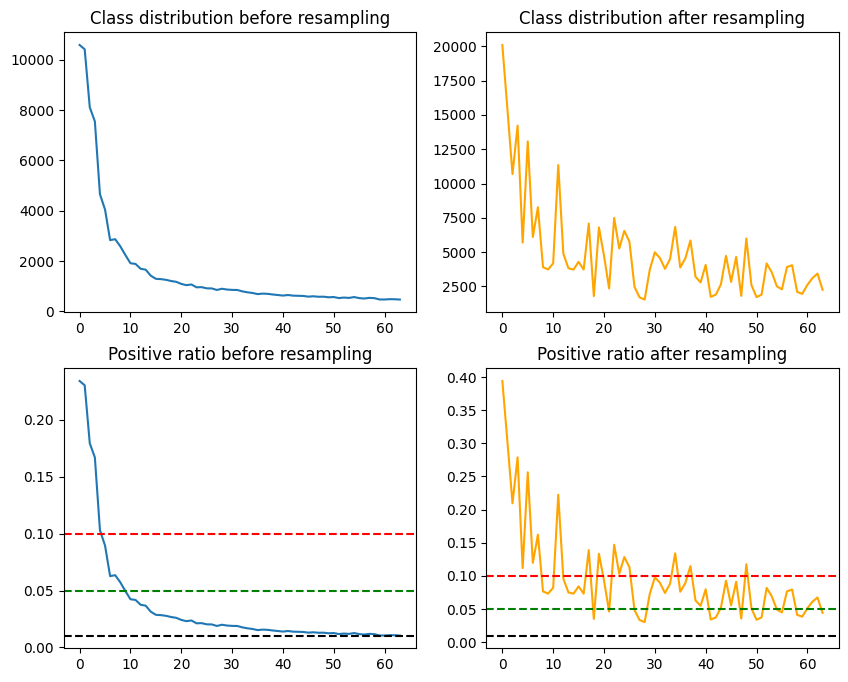

In [32]:
#plot the class distribution before and after resampling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)

ax[1, 0].plot(pos_ratio_before)
#create a line a y=0.1 and 0.05
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
ax[1, 1].set_title('Positive ratio after resampling')
plt.show()  

In [33]:
sampled_idx = resample(data, train_terms_df, strategy='distribution_balanced', I=51000)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape   

unique_idx, counts = np.unique(sampled_idx, return_counts=True)
print(len(unique_idx))
print(counts.max())

25641
11


In [34]:
diff = np.setdiff1d(idx, sampled_idx)
print(diff)

print(data['train_labels'][unique_idx[counts.argmax()]], '\n')
print(data['train_labels'][diff[0]], '\n')
print(data['train_labels'][diff[1]],  '\n')


[    3     5     6 ... 45238 45241 45246]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



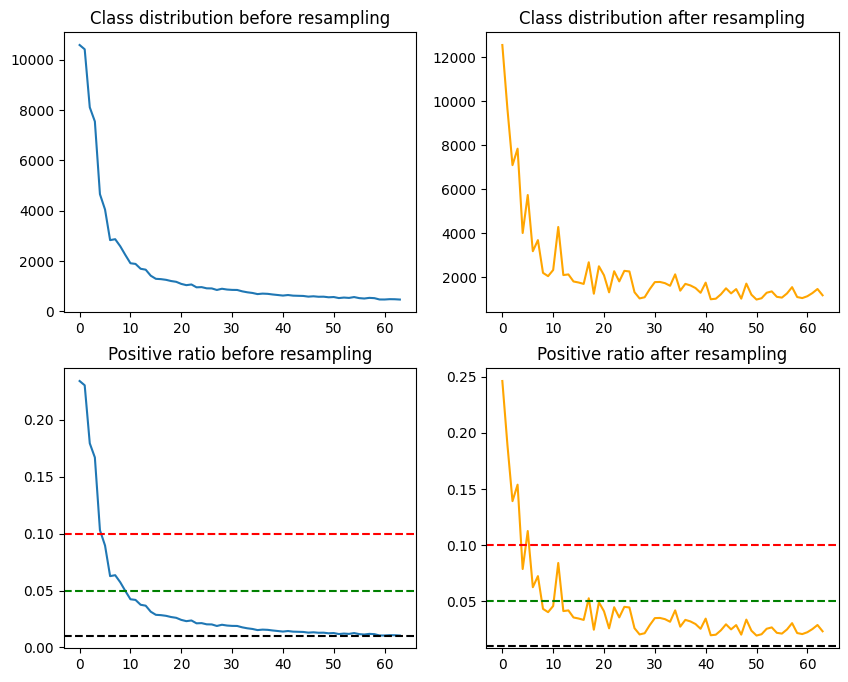

In [35]:
#plot the class distribution before and after resampling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)
ax[1, 0].plot(pos_ratio_before)
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')

ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].set_title('Positive ratio after resampling')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
plt.show()  

In [24]:
sampled_idx = resample(data, train_terms_df, strategy='log_pos', I=400000, t=0.2)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape   

(400000, 64)

In [25]:
unique_idx, counts = np.unique(sampled_idx, return_counts=True)
print(len(unique_idx))
print(counts.max())

idx = np.arange(0, len(data['train_labels']))

diff = np.setdiff1d(idx, sampled_idx)
print(diff)

print(data['train_labels'][unique_idx[counts.argmax()]], '\n')
print(data['train_labels'][diff[0]], '\n')
print(data['train_labels'][diff[1]],  '\n')


27247
1098
[    1     2     3 ... 56554 56555 56558]
[1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



In [26]:
counts.sort()
counts

array([   1,    1,    1, ...,  856,  926, 1098], shape=(27247,))

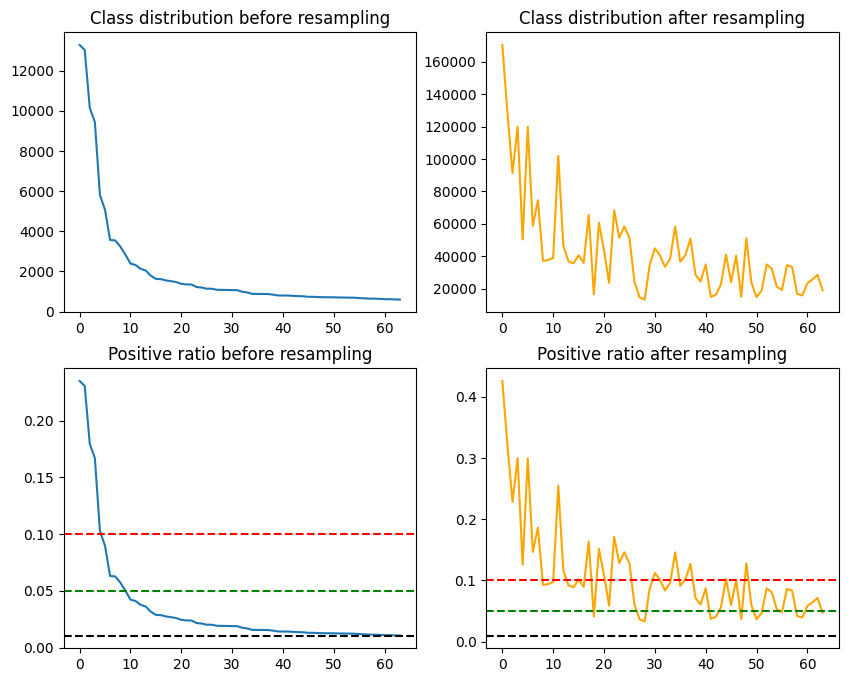

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)
ax[1, 0].plot(pos_ratio_before)
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')

ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].set_title('Positive ratio after resampling')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
plt.show()  

In [19]:
data.keys()

dict_keys(['train_sequences', 'val_sequences', 'train_labels', 'val_labels', 'mlb', 'top_terms', 'ia_scores', 'num_classes'])

In [29]:
sampled_idx = np.array(sampled_idx)

In [30]:
sampled_idx

array([35060, 47750, 22638, ..., 34657, 20386, 22556], shape=(400000,))

In [34]:
np.save('/mnt/d/ML/Kaggle/CAFA6/sampled_idx.npy', sampled_idx) 

In [32]:
data['train_labels']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(56559, 64))